# Introducción

En este documento exploraremos y analizaremos un dataset proporcionado por el profesorado que imparte la asignatura _Aprendizaje Automático_ en la Facultad de Informática, Universidad Complutense de Madrid. 

Implementaremos un modelo que realice predicciones de etiquetado binario utilizando este dataset, considerando múltiples configuraciones para el modelo, observando cómo varía su precisión y eficiencia. Para llevar a cabo estas tareas, utilizaremos las librerías _matplotlib, numpy y scikit-learn_.

El objetivo de este ejercicio es, por lo tanto, poner en práctica varias habilidades aprendidas durante el desarrollo de la asignatura a lo largo de los últimos meses. De esta forma, utilizaremos únicamente metodologías impartidas en la asignatura.

A continuación, realizaremos la carga de librerías, datos y un breve análisis.

In [4]:
import sys

sys.path

sys.executable



'/home/albertopastormr/anaconda3/bin/python'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# keras
from keras.models import Sequential
from keras.layers import Dense

# ficheros .py locales
from log_reg import LogReg # /log_reg.py
from neural_net import NeuralNet # /neural_net.py
from cross_validation import cv_config # /cross_validation
import drawing

/home/albertopastormr/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
!ls dataset/

tic-tac-toe.data  tic-tac-toe.names  tic-tac-toe_X.csv


In [7]:
df = pd.read_csv('dataset/tic-tac-toe.data', header=None)

print(f'number of instances:{df.shape[0]}, number of attributes:{df.shape[1]}')

number of instances:958, number of attributes:10


In [8]:
df.columns= ['p'+str(i) for i in range(0,df.shape[1]-1)] + ['y']

In [9]:
df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,y
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [10]:
df.describe()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,y
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


El dataset expone por cada tupla el contenido de las 9 posiciones del tablero de tres en raya, donde juegan dos jugadores denotados por *x* y *o*, así como la resolución de la partida, denotada con la cadena *positive* si ha ganado *x* o *negative* si ha ganado *o*. Por lo tanto, tenemos dos posibles etiquetas.

Leyendo el fichero _tic-tact-toe.names_ podemos conocer brevemente cómo se exponen los valores de las variables del dataset, concluyendo que en cada posición del tablero encontraremos una de tres opciones:

   > (x=player x has taken, o=player o has taken, b=blank)
    
Además, es relevante remarcar que se asume que el jugador *x* juega primero.

Cargamos los datos contenidos en el Dataframe *df* en arrays de Numpy para facilitar la manipulación de los datos en el código externo a este notebook.

In [11]:
feature_cols = df.columns[:-1]
label_cols = df.columns[-1]

In [12]:
X = np.asarray(df.loc[:, feature_cols])
y = np.asarray(df.loc[:, label_cols].ravel())
print(f'X.shape{X.shape}, y.shape{y.shape}')

X.shape(958, 9), y.shape(958,)


In [13]:
num_features = len(X[0])
num_labels = 2

Para reconocer mejor cómo se comportan los datos de *X* con respecto a sus etiquetas, *y*, dibujamos varios ejemplos en un tablero del juego *Tic tac toe*.

De esta forma, podemos conocer cómo se estructuran las variables características sobre el tablero y su relación con *y*, comprendiendo así mejor la naturaleza del problema.

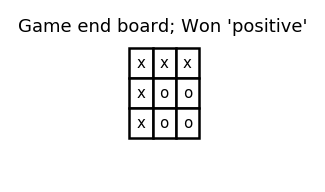

In [14]:
drawing.draw_end_game(X[0], y[0], categorical=True)

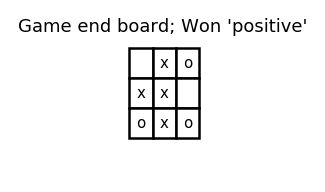

In [15]:
drawing.draw_end_game(X[500], y[500], categorical=True)

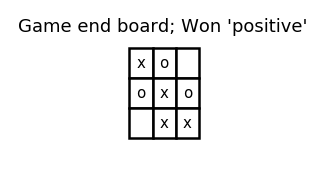

In [16]:
drawing.draw_end_game(X[210], y[210], categorical=True)

Observando estos ejemplos comprendemos que, efectivamente, al situarse en el tablero 3 fichas 'x' consecutivas en fila, columna o diagonal, se considera como ganador al jugador 'x'. En caso contrario, podemos afirmar que el ganador será 'o', ya que si el juego no llega a su fin por la victoria de 'x', llega a su fin por la victoria de 'o', no hay posibles empates. Este hecho encaja completamente con la naturaleza de las etiquetas *y*, ya que designan si ganó 'x' u 'o', no deja la posibilidad a empate.

# Preprocesamiento

Para facilitar la manipulación de los datos tanto de *X* como de *y*, vamos a convertir el contenido de ambos arrays de datos categóricos a datos númericos.

Para ello, vamos a realizar el siguiente mapeo:

- **y** : lo mapearemos correspondientemente dos veces, inicialmente pasará a ser 'x'(positive) u 'o'(negative), después lo convertiremos a '1'(x) o '0'(o). Es decir, guardaremos de *y* sus datos categóricos y sus datos numéricos, permitiendo así posteriores análisis más cómodos.
- **X** : ya que los datos iniciales ya contenían 'x' u 'o', solo realizaremos la conversión a '1'(x) o '0'(o). Mantendremos ambas versiones de *X*, al igual que hacíamos con *y*.

Consideraremos de ahora en adelante: 0-->'o', 1-->'x', 2-->'b', tanto para *X* como para *y*, aunque *y* no tenga la etiqueta 'b'.

Para este proceso, definiremos dos funciones que nos ayudarán en las conversiones:

In [17]:
convert_to_nums = lambda x : 1 if x == 'x' else (0 if x == 'o' else 2)
convert_to_nums = np.vectorize(convert_to_nums)

convert_to_cats = lambda x : 'x' if x == 1 else ('o' if x == 0 else 'b')
convert_to_cats = np.vectorize(convert_to_cats)

In [18]:
X_cat = X # inicialmente X ya esta en version categorica

In [53]:
X = convert_to_nums(X_cat)
print(X[0], f'X.shape:{X.shape}')

[1 1 1 1 0 0 1 0 0] X.shape:(958, 9)


Una vez convertida cada variable categórica en una variable numérica, producimos tres variables numéricas _dummy_ por cada variable numérica actual.

Cada posición del tablero quedará designada por tres variables numéricas que expongan los siguientes escenarios, según lo que se encuentre en el ejemplo en la posición concreta del tablero:
- [1,0,0] es 'o'
- [0,1,0] es 'x'
- [0,0,1] es 'b'

In [54]:
onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3,4,5,6,7,8])
X = onehotencoder.fit_transform(X).toarray()

In [55]:
print(X[500], f'X.shape:{X.shape}')

[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0.] X.shape:(958, 27)


A continuación, eliminamos todas las terceras columnas ya que es información redudante. Con solo 2 columnas por posición del tablero podemos representar las tres posibilidades de la siguiente forma: 
- x:'10' 
- o:'00'
- b:'01'

Por lo tanto, utilizamos dos columnas como si fueran dos bits, representando las posibilidades de cada posición en base a combinaciones de bits.

De esta forma, reducimos las dimensiones del dataset y, además, evitamos el fenómeno conocido como _dummy variable trap_. Las variables _dummy_ son las variables que hemos construido hasta ahora para resolver el problema, son variables que toman un valor 1 o 0 denotando la presencia o ausencia de una característica o categoría. En este caso, el escenario _dummy variable trap_ se encuentra y entiende por la correlación múltiple entre las variables que utilizamos para designar cada posición del tablero. 

In [56]:
X = np.delete(X, [0,3,6,9,12,15,18,21,24], axis=1)

In [57]:
print(X[500], f'X.shape:{X.shape}')

[0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.] X.shape:(958, 18)


Si interpretramos la transformación por el ejemplo *X[0]* podremos ver que es correcta al comparar el resultado con el tablero dibujado previamente sobre el mismo ejemplo. Actualizamos *num_features* para que se mantenga coherente.

In [69]:
num_features = len(X[0])

Realizamos un proceso muy similar con *y* en la conversión a _target_ numérico, a excepción de una interpretación previa en base al etiquetado 'positive' o 'negative. Esta interpretación solo la haremos una vez, por ello no guardamos la función que lo implementa. 

El valor de *y* 1 denota que la tupla de datos correspondiente pertenece a la clase "ha ganado x" mientras que su valor 0 denota que pertenece a la clase "no ha ganado X", lo cual es equivalente a "ha ganado o" ya que debe haber ganado uno de los dos jugadores, no hay posibilidad de empate.

In [63]:
y_cat = np.vectorize(lambda x: 'x' if x == 'positive' else 'o')(y)

In [64]:
y = convert_to_nums(y_cat)
print(y[0], f'y.shape:{y.shape}')

1 y.shape:(958,)


A continuación, probaremos diferentes tipos de modelos de predicción binaria para posteriormente realizar una comparación y conocer qué metodología de machine learning y con qué configuración ofrece mejores resultados para nuestro problema.

La implementación de los modelos basados en regresión logística y red neuronal de una capa oculta se encuentra en los ficheros `/log_reg.py` y `neural_net.py`. Estos ficheros exponen los modelos a través de clases cuyo objetivo es proporcionar al exterior una manipulación similar a la que exponen librerías como *scikit-learn*. El código de estos ficheros ha sido recogido de nuestras soluciones a las prácticas desarrolladas a lo largo del curso, con las modificaciones necesarias aplicadas para ser expuesto a través de clases.

Además, basándose en la teoría vista en clase y en la red neuronal de una capa oculta implementada en la práctica 4, el fichero `/multilayer_neural_net.py` implementa una red neuronal de n capas ocultas en una clase, similar a los modelos comentados previamente. Hemos decidido utilizar aun así en este notebook solamente la red neuronal de una capa oculta.

Creemos que encapsular los modelos en clases de esta forma facilita la manipulación de los mismos y permite una lectura de este documento más clara y sencilla. Por ello, no accederemos a métodos privados de las clases, utilizaremos accesos como `fit()`, `predict()`, etc, como si estuviéramos tratando con un modelo implementado en una librería.

Guardamos X e y en local para ahorrar el cómputo utilizado en el preprocesamiento para futuras cargas del notebook.

In [66]:
np.savetxt("dataset/tic-tac-toe_X.csv", X, delimiter=",")
np.savetxt("dataset/tic-tac-toe_y.csv", y, delimiter=",")

# Regresión logística

In [71]:
logreg = LogReg(num_features=num_features, num_labels=num_labels,reg_term=5)

In [72]:
logreg.fit(X=X, y=y)

In [73]:
y_pred = logreg.predict(X=X)

In [74]:
print(f'logreg accuracy:{logreg.accuracy_score(y,y_pred)}%')

logreg accuracy:65.34446764091858%


In [83]:
# no olvidar: 
poly = PolynomialFeatures(8)

Xreg = poly.fit_transform(X)
print(Xreg.shape)

(958, 24310)


# Red Neuronal

In [ ]:

# usar keras
# LINK -> https://www.kdnuggets.com/2017/09/neural-networks-tic-tac-toe-keras.html
# LINK -> https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

In [75]:
num_hidden_nodes = 25

In [76]:
nnet = NeuralNet(num_features=num_features, num_hidden_nodes=num_hidden_nodes, num_labels=2)

In [77]:
nnet.fit(X=X, y=y)

In [78]:
y_pred = nnet.predict(X=X)

In [79]:
print(f'neuralnet accuracy:{nnet.accuracy_score(y,y_pred)}%')

neuralnet accuracy:65.34446764091858%


# Support Vector Machines

In [80]:
C, sigma = 1.0, 0.1
gamma = lambda s: 1/(2*s**2)

In [81]:
svm = SVC(kernel='rbf', C=C, gamma=gamma(sigma))

In [82]:
svm.fit(X=X,y=y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=49.99999999999999,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [83]:
y_pred = svm.predict(X=X)

In [84]:
print(f'svm accuracy:{accuracy_score(y,y_pred)*100}%')

svm accuracy:100.0%


In [226]:
# TODO
# ya que acierta todas, hacemos train-cv split para ver como rinde con datos nuevos

In [233]:
# las siguientes celdas sirven para cargar modulos una y otra vez, para testear cambios en ficheros locales

In [ ]:
%load_ext autoreload

In [232]:
%autoreload 0 # 2 para cargar a cada ejecucion los modulos. 0 para no cargar